In [186]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from keras import models, layers


In [187]:
IMAGE_SIZE = 256 # Set your desired size
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 30

In [188]:
df = pd.read_csv('labels.csv')

In [189]:
def preprocess_image(image, label):
    image = tf.image.resize(image, [IMAGE_SIZE, IMAGE_SIZE])
    image = tf.image.convert_image_dtype(image, tf.float32)
    return image, label # label is the output we want the model to predict

In [190]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    'traffic_data',
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    # label_mode='categorical',
)

Found 4170 files belonging to 58 classes.


In [191]:
class_numbers = dataset.class_names

# Print the class names
print("Class Names:", class_numbers)

Class Names: ['0', '1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '4', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '5', '50', '51', '52', '53', '54', '55', '56', '57', '6', '7', '8', '9']


In [192]:
class_names = []
for i in class_numbers:
 class_names.append(df['Name'][int(i)])

In [193]:
class_names

['Speed limit (5km/h)',
 'Speed limit (15km/h)',
 'Dont Go straight',
 'Dont Go Left',
 'Dont Go Left or Right',
 'Dont Go Right',
 'Dont overtake from Left',
 'No Uturn',
 'No Car',
 'No horn',
 'Speed limit (40km/h)',
 'Speed limit (50km/h)',
 'Speed limit (30km/h)',
 'Go straight or right',
 'Go straight',
 'Go Left',
 'Go Left or right',
 'Go Right',
 'keep Left',
 'keep Right',
 'Roundabout mandatory',
 'watch out for cars',
 'Horn',
 'Speed limit (40km/h)',
 'Bicycles crossing',
 'Uturn',
 'Road Divider',
 'Traffic signals',
 'Danger Ahead',
 'Zebra Crossing',
 'Bicycles crossing',
 'Children crossing',
 'Dangerous curve to the left',
 'Dangerous curve to the right',
 'Speed limit (50km/h)',
 'Unknown1',
 'Unknown2',
 'Unknown3',
 'Go right or straight',
 'Go left or straight',
 'Unknown4',
 'ZigZag Curve',
 'Train Crossing',
 'Under Construction',
 'Unknown5',
 'Speed limit (60km/h)',
 'Fences',
 'Heavy Vehicle Accidents',
 'Unknown6',
 'Give Way',
 'No stopping',
 'No entry',
 

In [194]:
# Apply the preprocessing function to each image in the dataset
dataset = dataset.map(preprocess_image)

In [195]:
dataset

<_MapDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [196]:
len(dataset)

131

In [197]:
131*32

4192

tf.Tensor(
[21 32 23  6 21 50 38 50  0 12 12 16  0 52 15  4 14 17  1 45 21 50 21 25
 25 50 30 34 38 46 44 55], shape=(32,), dtype=int32)
['Speed limit (5km/h)', 'Speed limit (15km/h)', 'Dont Go straight', 'Dont Go Left', 'Dont Go Left or Right', 'Dont Go Right', 'Dont overtake from Left', 'No Uturn', 'No Car', 'No horn', 'Speed limit (40km/h)', 'Speed limit (50km/h)', 'Speed limit (30km/h)', 'Go straight or right', 'Go straight', 'Go Left', 'Go Left or right', 'Go Right', 'keep Left', 'keep Right', 'Roundabout mandatory', 'watch out for cars', 'Horn', 'Speed limit (40km/h)', 'Bicycles crossing', 'Uturn', 'Road Divider', 'Traffic signals', 'Danger Ahead', 'Zebra Crossing', 'Bicycles crossing', 'Children crossing', 'Dangerous curve to the left', 'Dangerous curve to the right', 'Speed limit (50km/h)', 'Unknown1', 'Unknown2', 'Unknown3', 'Go right or straight', 'Go left or straight', 'Unknown4', 'ZigZag Curve', 'Train Crossing', 'Under Construction', 'Unknown5', 'Speed limit (60km/h)', 'Fe

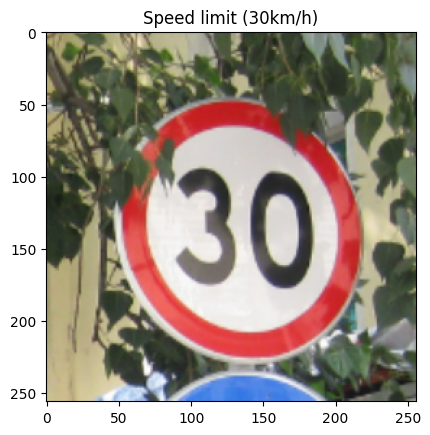

In [198]:
for image_batch,label_batch in dataset.take(1): # only take 1 batch
    print(label_batch)
    print(class_names)
    print(label_batch[10])
    print(image_batch[10])
    plt.imshow(image_batch[10].numpy().astype('uint8'))
    plt.title(class_names[label_batch[10]])

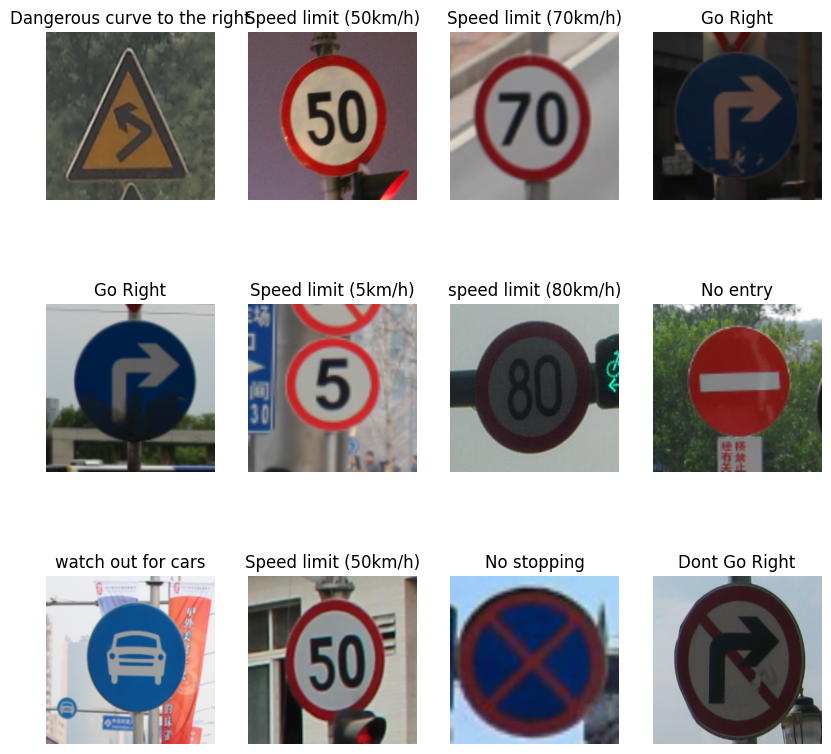

In [199]:
plt.figure(figsize=(10, 10))
for image_batch,label_batch in dataset.take(1):
   for i in range(12):
       plt.subplot(3,4,i+1) # it should be between 1 and 12 not 0 and 12 when defining a subplot.
       plt.imshow(image_batch[i].numpy().astype('uint8')) # it expects 3d array. it was float so we convert it to integer
       plt.axis('off')
       plt.title(class_names[label_batch[i]])

### Split dataset into train and test :

In [200]:
len(dataset)

131

In [201]:
# 80% ==> training
# 20% ==> 10% validation, will be used during training process,
# when we run epochs, after each epoch we do validation on the 10%,once we run all the epochs and have the final model, then we will use 10% test to measure accuracy of our model.

In [202]:
train_size = 0.8
len(dataset)*train_size

104.80000000000001

In [203]:
train_ds = dataset.take(105) # take first 105 samples, the first 105 batches.
len(train_ds)

105

In [204]:
test_ds = dataset.skip(105) # skip first 105 and get the remaining ones.
len(test_ds)

26

In [205]:
val_size = 0.1
len(dataset)*val_size

13.100000000000001

### needs 13 samples from my test dataset.

In [206]:
val_ds = test_ds.take(13)
len(val_ds)

13

In [207]:
def get_dataset_partitions_tf(ds, train_split= 0.8, val_split= 0.1, test_split= 0.1,shuffle=True,shuffle_size=10000):
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)# seed for predicability, if we do same seed everytime it will gives us same result, it can be anything.
    
    train_size = int(ds_size * train_split)
    train_ds = ds.take(train_size)
    
    val_size = int(ds_size * val_split)
    val_ds = ds.skip(train_size).take(val_size)
    
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [208]:
train_ds,val_ds,test_ds = get_dataset_partitions_tf(dataset)

In [209]:
len(train_ds)

104

In [210]:
len(val_ds)

13

In [211]:
len(test_ds)

14

In [212]:
# read image from the disk, then for next iteration(epoch) when we need same image, it will keep that image in memory to improve performance in my pipeline.it won't read the image again.
# prefetch will load the next set of batch from the disk, when the gpu is busy.
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE) # how many batches to load while gpu is training.
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE) 
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE) 

### Image Preprocessing

In [213]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip('horizontal_and_vertical'),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

In [214]:
resize_and_rescale = tf.keras.Sequential([
    # resizing the image why when we already have size 256 by 256
    # it is because the keras sequential layer will eventially go to our ultimate model, and when we have trained model then it start predicting, during prediction if we are supplying any image which is not 256 by 256, this Resizing will take care of resizing it.
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    # preprocessing pipeline.
    layers.experimental.preprocessing.Rescaling(1.0/255) # scale image between 0 and 255
    
])

In [215]:
input_shape = (BATCH_SIZE,IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 58
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32,(3,3), activation='relu', input_shape = (IMAGE_SIZE,IMAGE_SIZE)), # 32 features, filter size 3,3
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax') # it will normalize the probability of my classes.
    
    
])

In [216]:
model.build(input_shape=input_shape)

In [217]:
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_10 (Sequential)  (32, 256, 256, 3)         0         
                                                                 
 sequential_9 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d_18 (Conv2D)          (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d_18 (MaxPooli  (32, 127, 127, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_19 (Conv2D)          (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_19 (MaxPooli  (32, 62, 62, 64)          0         
 ng2D)                                               

In [218]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy'] # the metrics we use to track our training process, in each epoch what metric we use to track gradient descent.
)

In [219]:
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1, # just to print a lot of outputs to see what is going on
    validation_data= val_ds # help us track accuracy in each epoch
)

Epoch 1/30


104/104 [==============================] - 161s 1s/step - loss: 3.4470 - accuracy: 0.1416 - val_loss: 2.9131 - val_accuracy: 0.2284
Epoch 2/30
104/104 [==============================] - 148s 1s/step - loss: 2.4290 - accuracy: 0.3309 - val_loss: 1.9747 - val_accuracy: 0.3942
Epoch 3/30
104/104 [==============================] - 150s 1s/step - loss: 1.8402 - accuracy: 0.4338 - val_loss: 1.6417 - val_accuracy: 0.5192
Epoch 4/30
104/104 [==============================] - 152s 1s/step - loss: 1.5504 - accuracy: 0.5036 - val_loss: 1.5274 - val_accuracy: 0.5409
Epoch 5/30
104/104 [==============================] - 150s 1s/step - loss: 1.3891 - accuracy: 0.5650 - val_loss: 1.3980 - val_accuracy: 0.5433
Epoch 6/30
104/104 [==============================] - 142s 1s/step - loss: 1.3059 - accuracy: 0.5829 - val_loss: 1.1963 - val_accuracy: 0.6082
Epoch 7/30
104/104 [==============================] - 127s 1s/step - loss: 1.1638 - accuracy: 0.6146 - val_loss: 1.0821 - val_accuracy: 0.6250
Epoch 8/30

In [220]:
scores = model.evaluate(test_ds)

14/14 [==============================] - 7s 251ms/step - loss: 0.3225 - accuracy: 0.8862


In [221]:
scores

[0.3224789500236511, 0.8861607313156128]

In [222]:
history

In [223]:
history.params

{'verbose': 1, 'epochs': 30, 'steps': 104}

In [224]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [225]:
history.history['accuracy']

[0.14156079292297363,
 0.3309134840965271,
 0.4337567985057831,
 0.503629744052887,
 0.5650332570075989,
 0.5828796029090881,
 0.6146400570869446,
 0.6424682140350342,
 0.6878402829170227,
 0.6944948434829712,
 0.7159709334373474,
 0.745916485786438,
 0.7565033435821533,
 0.7743496894836426,
 0.7643678188323975,
 0.797943115234375,
 0.8033877611160278,
 0.8203266859054565,
 0.8197216987609863,
 0.8281911611557007,
 0.8333333134651184,
 0.8517846465110779,
 0.8345432281494141,
 0.8590441346168518,
 0.8605565428733826,
 0.8578342199325562,
 0.8714458346366882,
 0.8771929740905762,
 0.882637619972229,
 0.8814277052879333]

In [226]:
len(history.history['accuracy'])

30

In [227]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Loss')

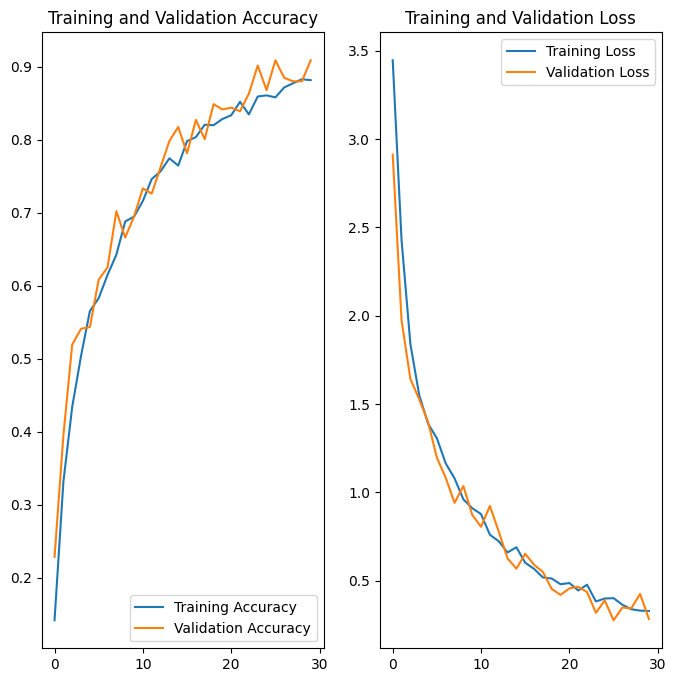

In [228]:
plt.figure(figsize=(8,8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

Text(0.5, 1.0, 'Training and Validation Accuracy')

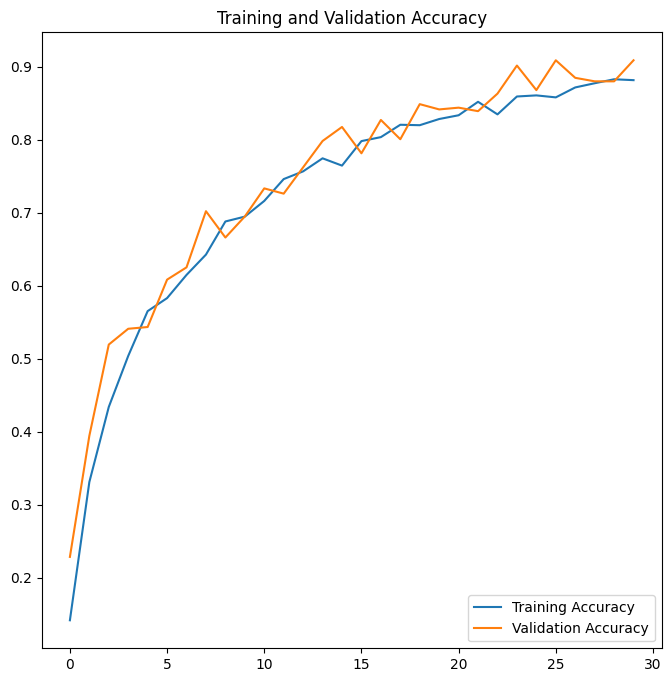

In [229]:
plt.figure(figsize=(8,8))

plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

first image to predict
first image actual label: Bicycles crossing
1/1 [==============================] - 0s 249ms/step
predicted label Bicycles crossing


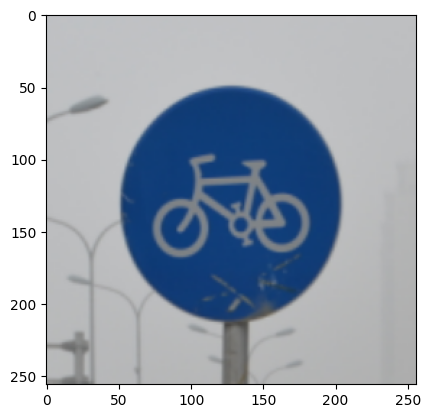

In [233]:
for image_batch, label_batch in test_ds.take(1): # we will take one batch for prediction
    
    first_image = (image_batch[0].numpy().astype('uint8'))
    first_label = label_batch[0].numpy()
    print('first image to predict')
    plt.imshow(first_image)
    print('first image actual label:', class_names[first_label])
    # what is my predicted label?
    batch_prediction = model.predict(image_batch) # this is batch prediction for 32 images
    print('predicted label',class_names[np.argmax(batch_prediction[0])]) # for first image

In [234]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy()) # converted the image into image array
    img_array = tf.expand_dims(img_array, 0) # create a batch
    
    predictions = model.predict(img_array)
    
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence # hundred percent confidence mean the accuracy for prediction is 100%

1/1 [==============================] - 0s 40ms/step


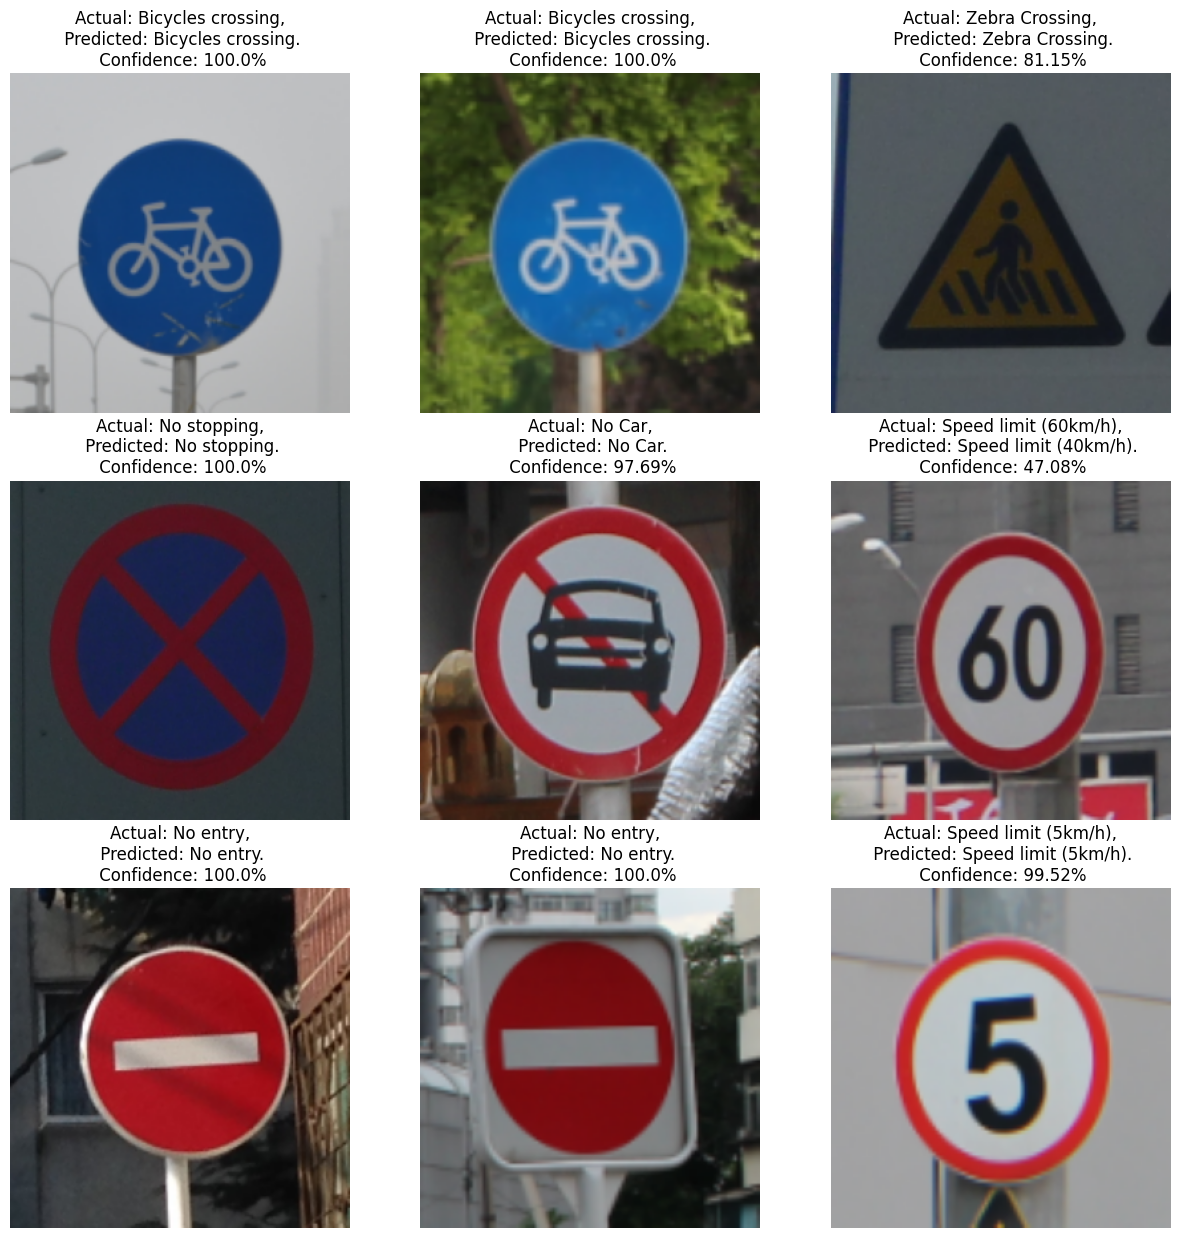

In [235]:
plt.figure(figsize=(15,15))
for images, labels in test_ds.take(1):
    for i in range(9): # i want predictions not on all 32 images just the first 9.
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        predicted_class, confidence = predict(model, images[i].numpy())
        actuall_clas = class_names[labels[i]]
        plt.title(f"Actual: {actuall_clas},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        plt.axis('off')

In [238]:
# get model version called 0, maximum of model versions. + 1 get the next model version
import os
model_version=max([int(i) for i in os.listdir("../models") + [0]])+1
model.save(f"../models/{model_version}")

INFO:tensorflow:Assets written to: ../models/3\assets


INFO:tensorflow:Assets written to: ../models/3\assets


In [239]:
loaded_model = tf.keras.models.load_model("../models/1/")
loaded_model